<a href="https://colab.research.google.com/github/syma-afsha/AI_LAB/blob/main/Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Final Exam for Deep Network Development course. First part (mandatory)**

This notebook contains the task to be solved in order to pass the exam.
This is the first part of the exam, which is compolsury in order to get a grade. It contains a task similar to what you have worked on during the semester, which consists on implementing a network architecture and a function.

Please note that, to **PASS** the Deep Network Development course you must **SUBMIT A SUCCESSFUL SOLUTION FOR THE FIRST PART**. If you **FAIL** the first part, you have the right to do the exam **ONE MORE TIME**. If you **FAIL AGAIN**, then unfortunately, you have failed the course. If you **PASS** the first part, then you get the weighted average of your quizzes and assignments as your final grade.

## Your information
Please fill the next cell with your information

**Full Name**:

**Neptun code:**

**Date:** 14/01/2025 9AM-11AM

## Task Description

#### Your task is to implement a custom architecture inspired by a image-to-image Diffusion like model, and the forward function. The model receives an intial image and a text as input (describes how the final image should look like) and generates an image according to the two.

#### Afterwards, make sure to run cell code number 1.2. to check if your implementation is correct.

#### This task should be **SOLVED IN 1 HOUR** and submitted to Canvas (download the .ipynb file). Please note that after 1 hour, the Canvas exam assignment will be closed and you cannot submit your solution.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#### **NO GPU IS NEEDED for this task**. No training nor any computationally expensive operation will be performed. This notebook runs on any computer using a cpu.

In [2]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device

## 1. Architecture

#### Please keep in mind that this architecture is purely imagined and should not correspond to any existing model / architecture. You will not find it on the internet.

Please right click the image and "Open image in a new tab" to view it better with zoom. Or download it from here: https://drive.google.com/file/d/1VWSuYR0Msa6M8FWnMJug3nZnPUytz3dS/view?usp=sharing

<br>
<br>

![](https://drive.google.com/uc?export=view&id=1VWSuYR0Msa6M8FWnMJug3nZnPUytz3dS)


#### Input image: Doge meme
By Atsuko Sato - https://kabosu112.exblog.jp/iv/detail/?s=9944144&i=201002%2F12%2F90%2Fa0126590_22301391.jpg, Fair use, https://en.wikipedia.org/w/index.php?curid=41704519

In [3]:
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

response = requests.get("https://upload.wikimedia.org/wikipedia/en/5/5f/Original_Doge_meme.jpg")
image = Image.open(BytesIO(response.content)).convert('RGB')
image = image.resize((256, 256))
image = np.rollaxis(np.array(image), 2, 0)

In [4]:
image.shape

(3, 256, 256)

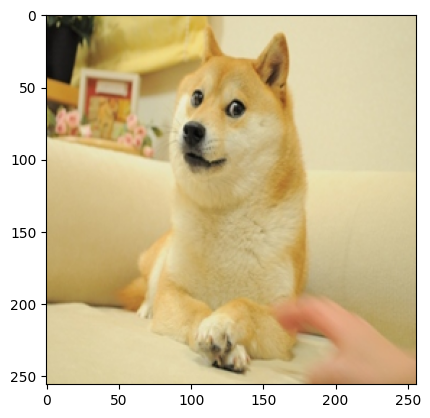

In [5]:
plt.imshow(np.moveaxis(image, 0,-1))

In [6]:
#Simple pre-processing
input_image = torch.tensor(image,dtype=torch.float32)
input_image = torch.unsqueeze(input_image, dim=0)
input_image.size()

torch.Size([1, 3, 256, 256])

#### Input text

In [7]:
text = "A dog wearing sunglasses and suit"

# Simple preprocessing the text
word_to_ix = {"A": 0, "dog": 1, "wearing": 2, "sunglasses": 3, "and": 4, "suit": 5}
lookup_tensor = torch.tensor(list(word_to_ix.values()), dtype=torch.long) # a tensor representing words by integers

vocab_size = len(lookup_tensor)

In [8]:
vocab_size

6

#### 1.1. Implement the architecture

In [11]:
class ImageEncoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ImageEncoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)  # Same padding
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(64, out_channels, kernel_size=3, stride=2, padding=1)  # Padding of 1
        self.relu2 = nn.ReLU()
        self.batch_norm = nn.BatchNorm2d(out_channels)

    def forward(self, input_image):
        x = self.conv1(input_image)   # First convolution
        print("1st conv shape", x.shape)
        x = self.relu1(x)             # Apply ReLU
        x = self.conv2(x)             # Second convolution
        print("2nd conv shape", x.shape)
        x = self.relu2(x)             # Apply ReLU
        x = self.batch_norm(x)        # Apply BatchNorm
        return x
class TextEncoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, out_channels):
        super(TextEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)  # Embedding layer
        self.conv_transpose = nn.ConvTranspose2d(
            in_channels=6,  # Reshape determines this
            out_channels=out_channels,
            kernel_size=2,
            stride=2
        )

    def forward(self, input_text):
        input_text = lookup_tensor.unsqueeze(0)
        # Embed the input text
        x = self.embedding(input_text)  # Shape: [batch_size, seq_len, embedding_dim]
        print("embedding shape", x.shape)

        # Reshape the embeddings to match ConvTranspose2D input
        batch_size = x.shape[0]
        x = x.view(batch_size, -1, 32, 32)  # Shape: [batch_size, embedding_dim // (32*32), 32, 32]
        print("reshaped embedding shape", x.shape)

        # Apply ConvTranspose2D
        x = self.conv_transpose(x)  # Output shape will depend on kernel/stride of ConvTranspose2D
        print("conv_transpose shape", x.shape)
        return x

In [20]:
class Attention(nn.Module):
    def __init__(self, encoder_dim, bottleneck_dim, attention_dim):
        super(Attention, self).__init__()
        # Define the layers
        self.linear1 = nn.Linear(in_features=encoder_dim * 64 * 64, out_features=64)
        self.linear2 = nn.Linear(in_features=32 * 64 * 64, out_features=64)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.linear3 = nn.Linear(in_features=64, out_features=1)  # As per the diagram

    def forward(self, text_encoder_outputs, image_encoder_features):
        # Process image_encoder_features
        context1 = image_encoder_features
        print(f"Shape of image_encoder_features: {context1.shape}")
        context1 = context1.view(context1.size(0), -1)  # Flatten
        print(f"Shape of view: {context1.shape}")
        context1 = self.linear2(context1)
        print(f"Shape of linear2: {context1.shape}")

        # Process text_encoder_outputs
        context2 = text_encoder_outputs
        print(f"Shape of text_encoder_outputs: {context2.shape}")
        context2 = context2.view(context2.size(0), -1)  # Flatten
        context2 = self.linear1(context2)
        print(f"Shape of linear1: {context2.shape}")

        # Combine the two contexts
        context = context1 + context2
        print(f"Shape of context: {context.shape}")

        context = self.relu(context)
        print(f"Shape of relu: {context.shape}")

        # Apply linear3 and softmax
        attention_weights = self.linear3(context)
        print(f"Shape of linear3: {attention_weights.shape}")

        attention_weights = self.softmax(attention_weights)
        print(f"Shape of softmax: {attention_weights.shape}")

        # Expand attention_weights to match (1, 32, 1, 64, 1)
        batch_size = attention_weights.size(0)
        attention_weights = attention_weights.unsqueeze(1).unsqueeze(1)  # (batch_size, 1, 1)
        attention_weights = attention_weights.repeat(1, 32, 1, 64, 1)
        print(f"Shape of attention_weights (reshaped): {attention_weights.shape}")

        context1 = context1.unsqueeze(1).unsqueeze(1)  # (batch_size, 1, 1, 64, 1)
        context1 = context1.repeat(1, 32, 1, 1, 1)  # Match target dimensions
        print(f"Shape of context1: {context1.shape}")

        # Element-wise multiplication and summation
        context = attention_weights * context1
        print(f"Shape of multiplication: {context.shape}")
        context = torch.sum(context, dim=1)  # Summing over the second dimension (dim=1)
        print(f"Shape of sum: {context.shape}")

        return context


class MyUNet(nn.Module):
    def __init__(self, text_in_channels, bottleneck_channels, out_channels, attention_dim):
        super(MyUNet, self).__init__()
        # Define the layers
        self.conv1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding="same")
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=32, kernel_size=3, padding="same")  # input

        self.conv3 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding="same")
        self.convtrans = nn.ConvTranspose2d(
            in_channels=96, out_channels=128, kernel_size=4, stride=2, padding=1
        )
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=64, kernel_size=3, padding="same")

        self.attention = Attention(text_in_channels, bottleneck_channels, attention_dim)

    def forward(self, text_features, image_features):
        x1 = image_features
        print(f"Shape of image_features: {x1.shape}")
        x1 = self.conv1(x1)
        print(f"Shape of conv1: {x1.shape}")
        x1 = self.relu(x1)
        x = self.pool(x1)
        print(f"Shape of pool: {x.shape}")
        x = self.conv2(x)
        print(f"Shape of conv2: {x.shape}")
        x = self.relu(x)

        x3 = text_features
        x3 = self.attention(x3, x)
        print(f"Shape of attention: {x3.shape}")
        x3 = self.conv3(x3)
        print(f"Shape of conv3: {x3.shape}")
        x3 = self.relu(x3)
        x5 = torch.cat((x3, x), dim=1)
        print(f"Shape of cat: {x5.shape}")
        x5 = self.convtrans(x5)
        print(f"Shape of convtrans: {x5.shape}")
        x5 = torch.cat((x5, x1), dim=1)
        print(f"Shape of cat: {x5.shape}")
        x5 = self.conv4(x5)
        print(f"Shape of conv4: {x5.shape}")
        x5 = self.relu(x5)

        return x5




In [21]:
class ImageDecoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ImageDecoder, self).__init__()
        # Define the BatchNorm layer
        self.batch_norm = nn.BatchNorm2d(in_channels)

        # Define the ConvTranspose2D layer
        self.conv_transpose = nn.ConvTranspose2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=2,
            stride=2
        )

        # Define the ReLU activation function
        self.relu = nn.ReLU()

    def forward(self, image_features):
        # Apply BatchNorm
        x = self.batch_norm(image_features)

        # Apply ConvTranspose2D
        x = self.conv_transpose(x)
        print("conv", x.shape)

        # Apply ReLU
        x = self.relu(x)

        return x

In [22]:
input_text=TextEncoder(vocab_size, 1024, 32)
text_encoder=input_text(lookup_tensor)
print(text_encoder.shape)

embedding shape torch.Size([1, 6, 1024])
reshaped embedding shape torch.Size([1, 6, 32, 32])
conv_transpose shape torch.Size([1, 32, 64, 64])
torch.Size([1, 32, 64, 64])


In [23]:
image=ImageEncoder(3, 64)
image_encoder=image(input_image)
print(image_encoder.shape)

1st conv shape torch.Size([1, 64, 256, 256])
2nd conv shape torch.Size([1, 64, 128, 128])
torch.Size([1, 64, 128, 128])


In [25]:
Unet=MyUNet(32, 64, 64, 64)
unet=Unet(text_encoder, image_encoder)
print(unet.shape)

Shape of image_features: torch.Size([1, 64, 128, 128])
Shape of conv1: torch.Size([1, 128, 128, 128])
Shape of pool: torch.Size([1, 128, 64, 64])
Shape of conv2: torch.Size([1, 32, 64, 64])
Shape of image_encoder_features: torch.Size([1, 32, 64, 64])
Shape of view: torch.Size([1, 131072])
Shape of linear2: torch.Size([1, 64])
Shape of text_encoder_outputs: torch.Size([1, 32, 64, 64])
Shape of linear1: torch.Size([1, 64])
Shape of context: torch.Size([1, 64])
Shape of relu: torch.Size([1, 64])
Shape of linear3: torch.Size([1, 1])
Shape of softmax: torch.Size([1, 1])
Shape of attention_weights (reshaped): torch.Size([1, 32, 1, 64, 1])
Shape of context1: torch.Size([1, 32, 1, 1, 64])
Shape of multiplication: torch.Size([1, 32, 1, 64, 64])
Shape of sum: torch.Size([1, 1, 64, 64])
Shape of attention: torch.Size([1, 1, 64, 64])
Shape of conv3: torch.Size([1, 64, 64, 64])
Shape of cat: torch.Size([1, 96, 64, 64])
Shape of convtrans: torch.Size([1, 128, 128, 128])
Shape of cat: torch.Size([1, 

In [26]:

class ImageToImageGenerator(nn.Module):
    def __init__(self, vocab_size, embedding_dim, image_channels, text_encoder_out_channels, image_encoder_out_channels, unet_out_channels, attention_dim): # 6, 1024, 3, 32, 64, 64, 64
        super(ImageToImageGenerator, self).__init__()
        # DEFINE the layers


    def forward(self, input_text, input_image):
        generated_image=input_text
        # SEND the input text to the TEXT ENCODER
        text_encoder=TextEncoder(vocab_size, embedding_dim, text_encoder_out_channels)
        text_encoder_output=text_encoder(input_text)


        # SEND the input image to the IMAGE ENCODER
        image_encoder=ImageEncoder(image_channels, image_encoder_out_channels)
        image_encoder_output=image_encoder(input_image)

        # SEND the text_features and image_features to the U-NET
        unet=MyUNet(text_encoder_out_channels, text_encoder_out_channels, unet_out_channels, attention_dim)
        unet_output=unet(text_encoder_output, image_encoder_output)

        # SEND the IMAGE FETURES from the U-NET to the IMAGE DECODER
        image_decoder=ImageDecoder(unet_out_channels, image_channels)
        image_decoder_output=image_decoder(unet_output)

        #return the image
        return generated_image

#### 1.2. Test your implementation
Expected output

torch.Size( [1, 3, 256, 256] )

In [19]:
#DONT MODIFY THIS BLOCK
########################################################
# vocab_size = vocab_size
embedding_dim = 1024
image_channels = 3
text_encoder_out_channels = 32
image_encoder_out_channels = 64
unet_out_channels = 64
attention_dim= 64
model = ImageToImageGenerator(vocab_size, embedding_dim, image_channels, text_encoder_out_channels, image_encoder_out_channels, unet_out_channels,attention_dim)

input_text = lookup_tensor

# Forward pass
output = model(input_text, input_image)
print('----------------------------------------------------------------')
print("Output Image Shape:", output.shape)

embedding shape torch.Size([1, 6, 1024])
reshaped embedding shape torch.Size([1, 6, 32, 32])
conv_transpose shape torch.Size([1, 32, 64, 64])
1st conv shape torch.Size([1, 64, 256, 256])
2nd conv shape torch.Size([1, 64, 128, 128])
Shape of image_features: torch.Size([1, 64, 128, 128])
Shape of conv1: torch.Size([1, 128, 128, 128])
Shape of pool: torch.Size([1, 128, 64, 64])
Shape of conv2: torch.Size([1, 32, 64, 64])
Shape of image_encoder_features: torch.Size([1, 32, 64, 64])
Shape of view: torch.Size([1, 131072])
Shape of linear2: torch.Size([1, 64])
Shape of text_encoder_outputs: torch.Size([1, 32, 64, 64])
Shape of linear1: torch.Size([1, 64])
Shape of context: torch.Size([1, 64])
Shape of relu: torch.Size([1, 64])
Shape of linear3: torch.Size([1, 1])
Shape of softmax: torch.Size([1, 1])
Shape of attention_weights (reshaped): torch.Size([1, 32, 1, 64, 1])
Shape of context1: torch.Size([1, 32, 1, 1, 64])
Shape of multiplication: torch.Size([1, 32, 1, 64, 64])
Shape of sum: torch.Si

For fun -- check the generated image, it should look something like this: https://drive.google.com/file/d/1NW3FwNSUj6bCyJd1TFvJUspLdmxR94m5/view?usp=sharing

<br>
<br>

![](https://drive.google.com/uc?export=view&id=1NW3FwNSUj6bCyJd1TFvJUspLdmxR94m5)


#### 1.2. Test your implementation
Expected output

torch.Size( [1, 3, 256, 256] )

# Extra Task for AI-lab: Pairing Images and Texts

In this task, the goal is to pairs 4 images with 4 texts using Hugging Face models and a Gradio interface. The system ensures no duplicate images or texts are inputted, generates embeddings for both (images and texts), and matches them based on semantic similarity, then printing the pairs.